# Отток клиентов

Для создания модели, которая будет прогнозировать возможность ухода клиента из "Бета-Банка", проведем специальное исследование. Для этого воспользуемся данными по имеющемуся оттоку клиентов. Данные будут представлять из себя таблицу с следующими признаками: 
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата
И в качестве целевого признака, будем использовать 
- Exited — факт ухода клиента
<br>
Именно целевой признак мы будем предсказывать в создаваемой нами модели. 

Описанная проблема может быть обозначена как задача классификации. Нам необходимо научить нашу модель распределять (классифицировать) данные по двум категориям - Уйдет или Не уйдет клиент из банка. 
В ходе нашего исследования мы распределим данные на обучающую, валидационную и тестовую выборки. Затем применим различные модели для обучения (с разными гиперпараметрами) и исследуем качество полученных моделей. И в конце, проанализируем и сравним полученные результаты. 

In [20]:
#Импортируем все используемые в проекте библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
from scipy.stats import binom, norm
from joblib import dump
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
# Напишите код здесь
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

# 1. Изучение исходных данных

В ходе изучения наших данных исследуем представленные типы данных, пропуски и дубликаты значений, проанализируем исходные данные на взаимосвязанность. 

In [21]:
#Считываем csv файлы с данными и сохраняем их в соответсвующие датафреймы
try:
    data = pd.read_csv('/datasets/Churn.csv')
except:
    data = pd.read_csv('Churn.csv')  

In [22]:
#Выведем первые 10 строчек из датафрейма
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [23]:
#Выведем общую информацию о данных 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [24]:
data = data.drop('RowNumber', axis = 1)
data = data.drop('CustomerId', axis = 1)
data = data.drop('Surname', axis = 1)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


**Вывод**: Из представленного можно сделать вывод для большинства данных их типы соотносятся с их смысловым значением. Для признака Tenure - количество лет, которое выражается целым числом, можно провести оптимизацию и заменить тип на *int*. 

In [26]:
#Изменить тип признака Tenure на int
data['Tenure'] = data['Tenure'].astype('Int32')

In [27]:
#Подсчитаем количество дубликатов
data.duplicated().sum()

0

**Вывод**: дубликаты в данных отутствуют. 

In [28]:
#Определим число пропущенных значений 
data.isna().sum()

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [29]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())

**Вывод**: в значениях Tenure имеется 909 пропущенных значений, т.е. около 9% всех значений. 

In [30]:
#Оценим взаимосвязь данных, исключив неимеющие для этой процедуры смысла признаки 
bool_qualities = ['Exited','HasCrCard', 'IsActiveMember']
data.drop(bool_qualities, axis = 1).corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
CreditScore,1.000000,-0.003965,-0.000060,0.006268,0.012238,-0.001384
Age,-0.003965,1.000000,-0.012606,0.028308,-0.030680,-0.007201
Tenure,-0.000060,-0.012606,1.000000,-0.007535,0.011409,0.010049
Balance,0.006268,0.028308,-0.007535,1.000000,-0.304180,0.012797
NumOfProducts,0.012238,-0.030680,0.011409,-0.304180,1.000000,0.014204
EstimatedSalary,-0.001384,-0.007201,0.010049,0.012797,0.014204,1.000000


**Вывод**: Между значениями признаков нет сильной положительной или отрицательной корреляции. 

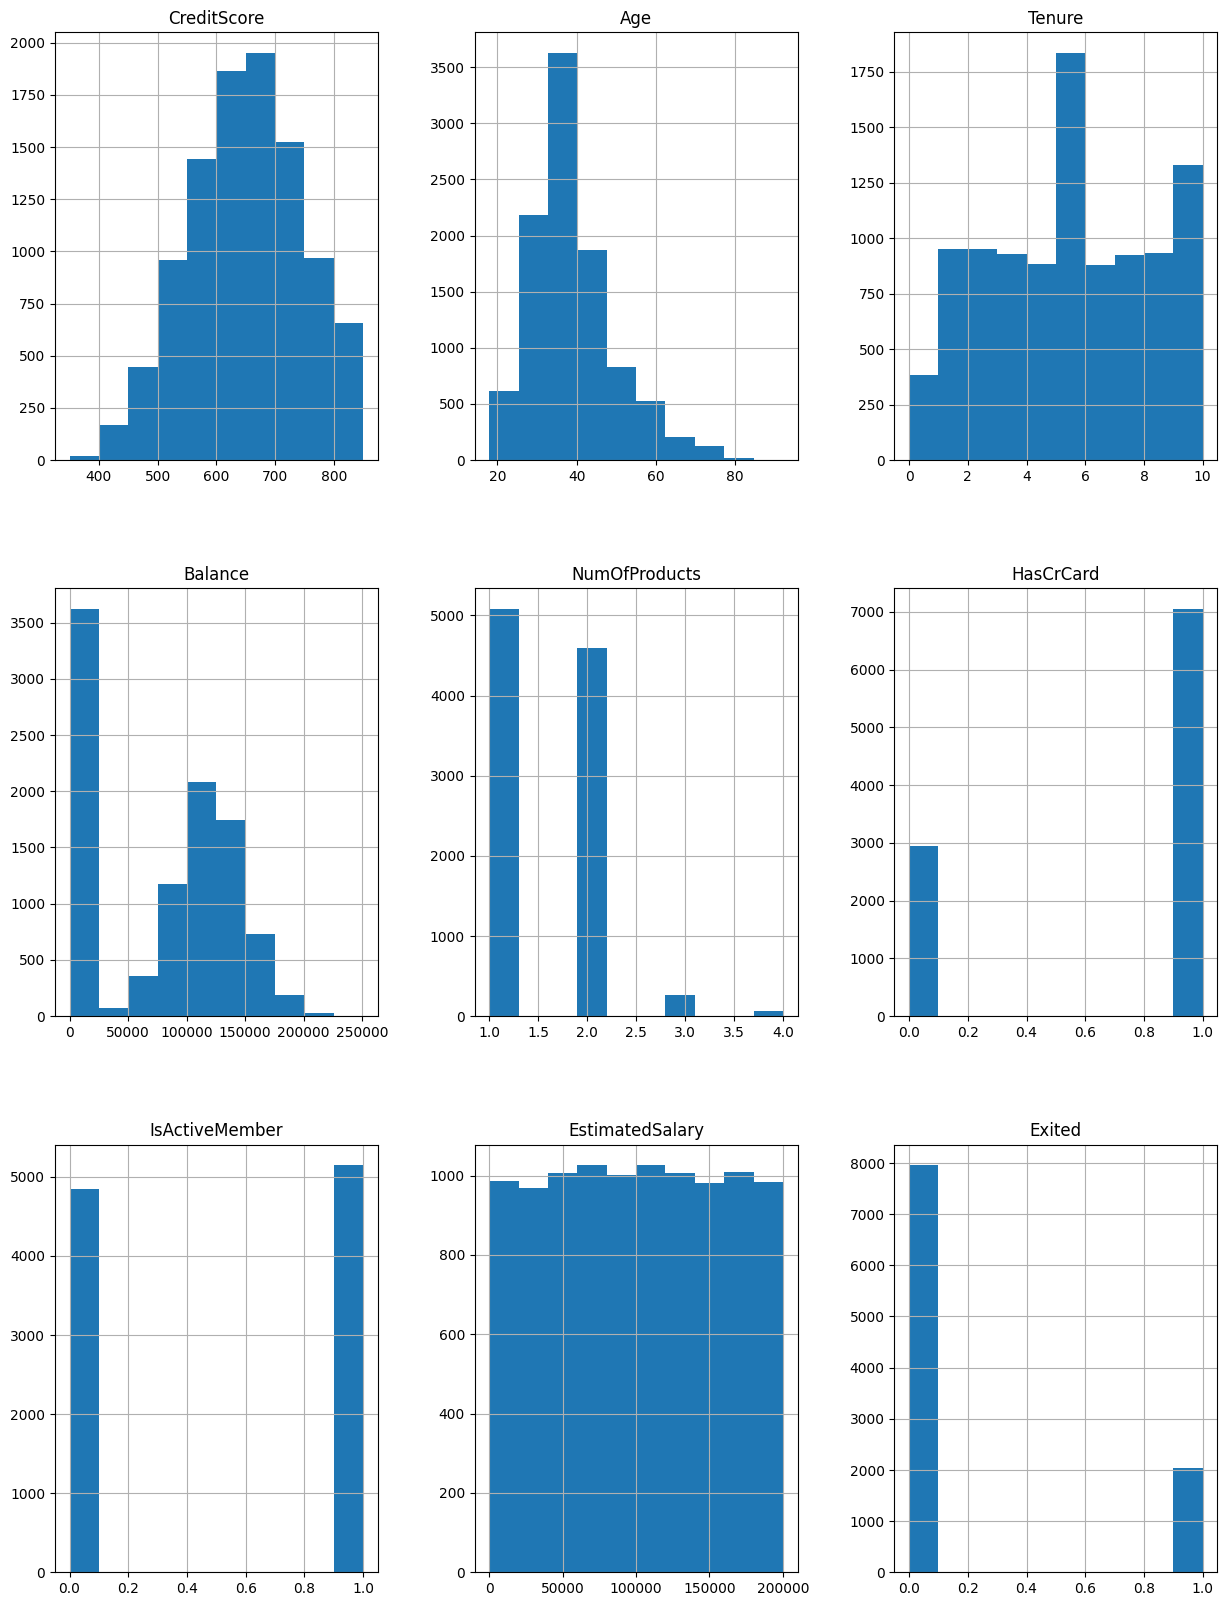

In [31]:
#Построение гистограмм
data.hist(figsize=(15,20));

In [32]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.99790,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.76001,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.00000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.00000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.00000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.00000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.00000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


**Вывод**: из гистограмм и статистической таблицы можно сделать вывод, что аномально высоких или низких значений в данных не обнаружено. Также видно, что в разных данных совершенно разные порядки разброса, что может некоректно сказаться на прогнозировании и важности тех или иных признаков. 

**Общий вывод**: в ходе изучения представленных данных не выявлено дубликатов значений, выявлены пропуски в признаке, отвечающем за количество лет, в течение которых человек является клиентом банка. Не найдено корреляции между какими-либор признаками и не выявлено аномальных значений. 

# 2. Подготовка модели обучения 

Для создания модели разобьем нашу иходную выборку на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного набора сделаем равными, а обучающую сделаем в три раза больше каждого из них, то есть разобьем данные в сотношении 3:1:1

In [34]:
#Проверим исходный размер выборки
data.shape

(10000, 11)

In [35]:
#Разобьем на две части 80% и 20%, выделим тем самым тестовую выборку df_test
df, df_test = train_test_split(data, test_size = 0.2, random_state = 12345, stratify = data['Exited'])

In [36]:
#Разобьем данные на две части - на обучающую и на валидационную выборку
df_train, df_valid = train_test_split(df, test_size=0.25, random_state = 12345, stratify = df['Exited'])

In [37]:
#Проверим конечные размеры выборок 
print('Train = ', df_train.shape)
print('Valid = ', df_valid.shape)
print('Test = ', df_test.shape)

Train =  (6000, 11)
Valid =  (2000, 11)
Test =  (2000, 11)


**Вывод**: подготовленные выборки соответсвуют соотношению 3:1:1

Целевым признаком в нашей модели будет **Exited** - факт ухода клиента из банка. 

Произведем кодирование наших категориальных переменных - **Gender** и **Geography**. 

In [38]:
#Создаем объект encoder
enc = OneHotEncoder(sparse = False, drop = 'first')
df_train_category = df_train[['Gender', 'Geography']]
transformed = enc.fit_transform(df_train_category)
df_train_category = pd.DataFrame(transformed, index = df_train.index, columns=enc.get_feature_names())
df_train = df_train.join(df_train_category)
df_train = df_train.drop(['Gender', 'Geography'], axis = 1)
df_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,x0_Male,x1_Germany,x1_Spain
5536,636,45,5,0.00,2,1,1,159463.80,0,1.0,0.0,1.0
8530,808,33,2,103516.87,1,1,0,113907.80,0,0.0,0.0,0.0
1762,758,34,1,154139.45,1,1,1,60728.89,0,0.0,0.0,0.0
9090,809,39,5,0.00,1,1,0,77705.75,0,0.0,0.0,0.0
8777,603,24,1,165149.13,2,1,0,21858.28,0,1.0,0.0,1.0


In [39]:
#Применим функцию trasmorm к валидационной выборке
df_valid_category = df_valid[['Gender', 'Geography']]
transformed = enc.transform(df_valid_category)
df_valid_category = pd.DataFrame(transformed, index = df_valid.index, columns=enc.get_feature_names())
df_valid = df_valid.join(df_valid_category)
df_valid = df_valid.drop(['Gender', 'Geography'], axis = 1)
df_valid.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,x0_Male,x1_Germany,x1_Spain
9375,659,48,4,123593.22,2,1,0,82469.06,1,1.0,1.0,0.0
9536,550,42,10,128707.31,1,1,0,63092.65,1,0.0,1.0,0.0
6344,850,41,3,0.00,2,1,0,128892.36,0,1.0,0.0,0.0
4357,755,36,8,0.00,2,1,0,176809.87,0,1.0,0.0,0.0
9120,703,58,4,92930.92,1,0,1,85148.78,0,1.0,0.0,1.0


In [40]:
#Применим функцию transform к тестовой выборке
df_test_category = df_test[['Gender', 'Geography']]
transformed = enc.transform(df_test_category)
df_test_category = pd.DataFrame(transformed, index = df_test.index, columns=enc.get_feature_names())
df_test = df_test.join(df_test_category)
df_test = df_test.drop(['Gender', 'Geography'], axis = 1)
df_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,x0_Male,x1_Germany,x1_Spain
7837,850,48,2,0.00,1,1,0,169425.30,1,1.0,0.0,1.0
9505,651,28,10,79562.98,1,1,1,74687.37,0,1.0,0.0,0.0
6208,714,34,10,0.00,2,1,1,80234.14,0,1.0,0.0,0.0
5642,782,41,4,0.00,1,1,0,132943.88,0,0.0,0.0,1.0
9643,521,41,2,0.00,2,1,1,113089.43,0,0.0,0.0,0.0


In [41]:
#Выберем переменные для признаков и для целевого признака
features_train = df_train.drop(['Exited'], axis=1)
target_train = df_train['Exited']
features_valid = df_valid.drop(['Exited'], axis=1) 
target_valid = df_valid['Exited'] 
features_test = df_test.drop(['Exited'], axis=1) 
target_test = df_test['Exited'] 

Как было указано раннее, у разных признаков разные диапазоны изменений (разные масштабы). Это может значительно исказить нашу модель. Избежим этой проблемы и приведем данные к одному масштабу. 

In [42]:
#Зададим числовые признаки
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [43]:
scaler = StandardScaler()
pd.options.mode.chained_assignment = None
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,x0_Male,x1_Germany,x1_Spain
5536,-0.143332,0.577533,-0.001274,-1.220573,0.797767,1,1,1.029613,1.0,0.0,1.0
8530,1.632702,-0.564119,-1.092954,0.435807,-0.916018,1,0,0.237986,0.0,0.0,0.0
1762,1.116413,-0.468981,-1.456847,1.245822,-0.916018,1,1,-0.686104,0.0,0.0,0.0
9090,1.643028,0.006707,-0.001274,-1.220573,-0.916018,1,0,-0.391097,0.0,0.0,0.0
8777,-0.484083,-1.420358,-1.456847,1.421989,0.797767,1,0,-1.361559,1.0,0.0,1.0


**Вывод**: подготовленные данные теперь находятся в одном масштабе. 

Проведем теперь анализ баланса: изучим как часто в целов признаке встречается класс "1" и класс "2". 

0    0.7963
1    0.2037
Name: Exited, dtype: float64


<AxesSubplot:>

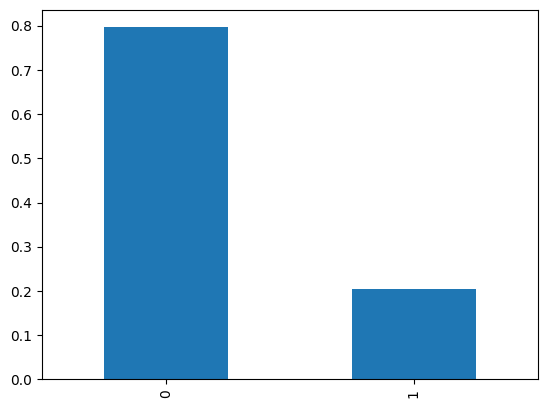

In [44]:
class_frequency = data['Exited'].value_counts(normalize = True)
print(class_frequency)
class_frequency.plot(kind='bar')

**Вывод**: класс *0* встречается в 4 раза чаще класса *1*. 

**Общий вывод**: для подготовки к моделированию данные были разбиты на три выборки - тренировочную, валидационную и тестовую. Были выделены целевой признак и остальныеи исходные данные были пробразованы к одному масштабу. Также обнаружено, что класс **0** встречается в четыре раза чаще класса **1**. 

# 3. Моделирование

## 3.1 Тестовое тестирование

Проведем изначально тестовое моделирование без учета баланса классов и дополнительной настройки параметров. В качестве модели будет выбрано **Решающее дерево**.  

In [45]:
#Создание и обучение модели решающего дерева 
model = DecisionTreeClassifier(random_state = 12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid) 
accuracy_valid = accuracy_score(target_valid, predicted_valid)
print('Accuracy = ', accuracy_valid)

Accuracy =  0.789


**Вывод**: не проводя анализ балансов классов, после создания тестовой модели решающего дерева было получено значение accuracy равное 0.79

Проанализируем частоты классов в результатах предсказаний решающего дерева.

0    0.7815
1    0.2185
dtype: float64


<AxesSubplot:>

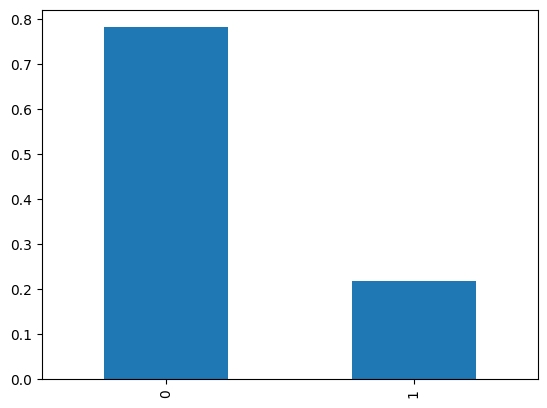

In [46]:
#Проверка частоты предсказания попадания в разные классы 
predicted_valid = pd.Series(model.predict(features_valid))
class_frequency = predicted_valid.value_counts(normalize = True)
print(class_frequency)
class_frequency.plot(kind='bar')

Проанализируем адекватность нашей модели, сравнив ее с константной моделью - моделью, которая прогнозируем всем попадание в класс 0. 

In [47]:
#Создадим константную модель и протестируем ее
target_pred_constant = pd.Series([0]*len(target_valid))
print(accuracy_score(target_valid, target_pred_constant))

0.7965


**Вывод**: константная модель показывает результат даже лучше исходной модели решающего дерево. Следовательно проверку на адекватность наша исходная модель не прошла. 

Воспользуемся теперь более точными для такой модели характеристиками как точность и полнота (precision и recall), а также среднегармоническое этих характеристик - f1. 

In [48]:
#Выведем матрицу ошибок 
print(confusion_matrix(target_valid, predicted_valid))

[[1367  226]
 [ 196  211]]


In [49]:
#Расчитаем полноту
print('Recall =', recall_score(target_valid, predicted_valid))

Recall = 0.5184275184275184


In [50]:
#Расчитаем точность
print('Precision = ', precision_score(target_valid, predicted_valid))

Precision =  0.482837528604119


In [51]:
#Расчитаем характеристику f1
print('F1 = ', f1_score(target_valid, predicted_valid))

F1 =  0.5000000000000001


In [52]:
#Расчитаем также значение auc_roc
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC =', auc_roc)

AUC-ROC = 0.6882784170919763


**Вывод**: значение auc roc = 0.68 говорит о том, что модель дает предсказания лучше, чем случайная. 

**Вывод**: после проведения тестового тестирования модели несбалансированной логичстической регрессии были получены следующие результаты: 
- **Recall** = 0.5
- **Precision** = 0.47
- **F1** = 0.48 <br>
- **auc_roc** = 0.68  <br>
Полученные данные не являются достаточными для создания хорошей предсказательной модели. 

## 3.2 Сбалансированная логистическая регрессия

Учтем теперь тот факт, что представленные классы не являются сбалансированными и воспользуемся разными методами для их балансироваки. Сначала проверим, как изменятся параметры модели логистической регресии.  

In [53]:
#Обучим сбалансированную модель Логичстической регрессии 
model = LogisticRegression(random_state=12345, solver='liblinear',class_weight = 'balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))
print('Recall:', recall_score(target_valid, predicted_valid))
print('Precision:', precision_score(target_valid, predicted_valid))
#Расчитаем также значение auc_roc
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC =', auc_roc)

F1: 0.5113043478260869
Recall: 0.7223587223587223
Precision: 0.39569313593539707
AUC-ROC = 0.791802588412758


**Вывод**: Сбалансированная логистическая регрессия дает следующие результаты: **F1** - 0.47, **Recall** = 0.68, **Precision** = 0.36. **AUC-ROC** = 0.77. Заметного улучшения результатов она не дает.

Проведем балансировку теперь другим способом - с помощью увеличения выборки (upsampling) и уменьшения выборки (downsampling).

Метод **upsampling**

In [54]:
#Реализиуем функцию, которая проводит увеличивает  количество положительных объектов
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled


In [55]:
#Применим логистическую регрессию к увеличенной выборке 
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid) 
result = f1_score(target_valid, predicted_valid)
    
#Расчитаем также значение auc_roc

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('F1 =', result )
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC =', auc_roc)

F1 = 0.5081545064377684
AUC-ROC = 0.7918750800106732


**Вывод**: применение логистической регрессии к увеличенной выборке дает результат параметра **f1** =  0.48. Параметр **auc-roc** в этом случае равен 0.77. Значительного улучшения этой характеристики не достигнуто. 

Метод **downsampling** 

In [56]:
#Реализиуем функцию, которая проводит уменьшает количество отрицательных объектов
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [57]:
#Применим логистическую регрессию к уменьшенной выборке 
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid) 
result = f1_score(target_valid, predicted_valid)
    
#Расчитаем также значение auc_roc

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('F1 =', result )
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC =', auc_roc)

F1 = 0.5047210300429185
AUC-ROC = 0.7913244523414015


**Вывод**: применение логистической регрессии к уменьшенной выборке дает результат параметра f1 =  0.48. Параметр **auc-roc** в этом случае равен 0.77. Значительного улучшения этой характеристики не достигнуто. 

## 3.3 Сбалансированный случайный лес

Проведем теперь моделирование с помощью другой модели - с помощью случайного леса, используя увеличенную выборку. Будем подбирать оптимальные параметры указанной модели, таким образом определив наилучшую. 

In [58]:
#Обучим модель случайного леса и подберем наилуший параметр количества деревьев
best_model_random_tree = None
best_result_random_tree = 0
best_number_of_trees = 0
best_number_of_depth = 0
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
#Создадим вложенный цикл по количеству деревьев и по максимальной глубине
for est in range(1, 30, 1):
        for depth in range (1, 25, 1):
            model_random_tree = RandomForestClassifier(random_state=12345, n_estimators= est, max_depth = depth) 
            model_random_tree.fit(features_upsampled, target_upsampled)
            predicted_valid = model_random_tree.predict(features_valid)
            result = f1_score(target_valid, predicted_valid)
            if result > best_result_random_tree:
                best_model_random_tree = model_random_tree
                best_result_random_tree = result
                best_number_of_trees = est
                best_number_of_depth = depth

print("F1 наилучшей модели на валидационной выборке:", best_result_random_tree)
print('Количество деревьев', best_number_of_trees)
print('Максимальная глубина', best_number_of_depth)
#Расчитаем также значение auc_roc
probabilities_valid = best_model_random_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC =', auc_roc)

F1 наилучшей модели на валидационной выборке: 0.6372950819672131
Количество деревьев 24
Максимальная глубина 8
AUC-ROC = 0.8670920535327316


**Вывод**: модель случайного дерева с количеством деревьев 24 и максимальной глубиной 8 для увеличенной выборки, продемонстировала лучший результат для  **F1** = 0.63. Параметр **AUC-ROC** в этом случае равен 0.86. 

# 4. Итоговое тестирование

Проведем итоговое тестирование на тестовой выборке.

In [59]:
#Проверим качество выбранной модели на тестовой выборке для лучшего дерева с увеличенной выборкой 
predicted_test = best_model_random_tree.predict(features_test)
print('f1 =', result)
probabilities_valid = best_model_random_tree.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_valid)
print('AUC-ROC =', auc_roc)

f1 = 0.6053333333333333
AUC-ROC = 0.8572463063988487


**Вывод**: Таким образом, для  модели случайного дерева было получено наилучшее значение параметра F1 = 0.6 на тестовой выборке. Параметр AUC-ROC в этом случае равен 0.86.

# Выводы:

В ходе нашего исследования мы проанализировли исходные данные и составили по ним модель, которая позволяет прогнозировать покинет ли клиент банк или нет. Исследование было сведено к задаче классификации, поскольку выбор осуществлялся среди конечного набора действий - уйдет или нет, и сводилось к изучению одного целевого признака. 



После предобработки данных были обнаружены пропуски определенных значений в признаке Tenure. Обнаруженные данные с пропусками были удалены из текущей выборки для построения корректной модели. Также были изучены возможные взаимосвязи между исходными признаками, но сильных коррелляций обнаружено не было. 

В ходе моделирования были протестированы - исходная выборка на модели логичестической регрессии, логистическая регрессия на сбалансированных разными способами выборках и определены характеристики качества моделей **F1** и **AUC-ROC**. Полученные модели не удовлетворяли поставленному требованию по метрике F1 = 0.59. 

Для дальнейшего исследования была протестирована модель случайного леса с разными параметрами этой модели (количеством деревьев, максимальной глубиной). Данное тестирование проводилось на увеличенной и уменьшенной выборке. Была найдена наилучшая модель. 

Модель, показавшая наилучшие результаты, может быть описана следующим образом:
Модель Случайного Леса с количеством деревьев равным **24** и максимальной глубиной равной **8**. 
Полученные результаты метрик качества модели на валидационной выборке **F1** = 0.63, **AUC-ROC** = 0.85.

Модель была протестирована на тестовой выборке со следующими результатами **F1** = 0.6, **AUC-ROC** = 0.86. 